# SpatialClustering_SpatialProteomicsData

This tutorial demonstrates how to identify spatial domains on spatial proteomics data using Pysodb and Spaceflow.

The reference paper can be found at https://www.nature.com/articles/s41467-022-31739-w and https://www.cell.com/fulltext/S0092-8674(18)31100-0.

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Scanpy is a package for single-cell RNA sequencing analysis.
import scanpy as sc

In [3]:
# from SpaceFlow package import SpaceFlow module
from SpaceFlow import SpaceFlow

In [4]:
# Imports a palettable package
import palettable
# Create three variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_pspace = palettable.cartocolors.diverging.TealRose_7.mpl_colormap
cmp_domain = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_ct = palettable.cartocolors.qualitative.Safe_10.mpl_colors

When encountering the error "No module name 'palettable'", users need to activate conda's virtual environment first at the terminal and run the following command in the terminal: "pip install palettable". This approach can be applied to other packages as well, by replacing 'palettable' with the name of the desired package.

## Streamline development of loading spatial data with Pysodb

In [5]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [6]:
# Initialize the sodb object
sodb = pysodb.SODB()

In [7]:
# Define names of the dataset_name and experiment_name
dataset_name = 'keren2018a'
experiment_name = 'p4'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[p4] in dataset[keren2018a]


## Perform SpaceFlow to spatial clustering for spatial proteomics data

In [8]:
# Create SpaceFlow Object
sf = SpaceFlow.SpaceFlow(
    count_matrix=adata.X, 
    spatial_locs=adata.obsm['spatial'], 
    sample_names=adata.obs_names, 
    gene_names=adata.var_names
)

When encountering the error "Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()." In the "SpaceFlow.py" file from the SpaceFlow package, the user is advised to make the following modifications within the init function. Replace "elif count_matrix and spatial_locs:" with "elif count_matrix is not None and spatial_locs is not None:". Additionally, modify "if gene_names:" and "if sample_names:" to "if gene_names is not None:" and "if sample_names is not None:" respectively. The above modifications ensure that the if statement returns a single boolean value respectively.

In [9]:
# Preprocess data
sf.preprocessing_data()

When dealing with anndata (adata) where the count or expression matrix is extremely sparse, or where there are a very limited number of features (as is often the case with spatial proteomics data), it may be preferable to forego data preprocessing. This is because over-processing in these instances could lead to errors or diminished performance in downstream tasks. To skip preprocessing, user will need to make modifications to the preprocessing_data function within the "SpaceFlow.py" file of the SpaceFlow package. Specifically, user should comment out the sc.pp.normalize_total(), sc.pp.log1p(), and sc.pp.highly_variable_genes() functions.

When encountering the error "Error: You can drop duplicate edges by setting the 'duplicates' kwarg", in "SpaceFlow.py" from the SpaceFlow package, modify the preprocessing_data function by: (1) removing target_sum=1e4 from sc.pp.normalize_total(); (2) changing the flavor argument to 'seurat' in sc.pp.highly_variable_genes(); (3) Save and rerun the analysis.

When encountering the error "Error: module 'networkx' has no attribute 'to_scipy_sparse_matrix'", users should first activate the virtual environment at the terminal and then downgrade NetworkX with the following command："pip install networkx==2.8". This will ensure that the correct version of NetworkX is installed within the specified virtual environment.

In [10]:
# Train a deep graph network model
embedding = sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=50, 
    lr=1e-3, 
    epochs=1000, 
    max_patience=50, 
    min_stop=100, 
    random_seed=42, 
    gpu=0, 
    regularization_acceleration=True, 
    edge_subset_sz=1000000
)

Epoch 2/1000, Loss: 1.407133936882019
Epoch 12/1000, Loss: 1.152597188949585
Epoch 22/1000, Loss: 0.8628092408180237
Epoch 32/1000, Loss: 0.6013652682304382
Epoch 42/1000, Loss: 0.44088295102119446
Epoch 52/1000, Loss: 0.3423008918762207
Epoch 62/1000, Loss: 0.27678847312927246
Epoch 72/1000, Loss: 0.243853360414505
Epoch 82/1000, Loss: 0.2291972041130066
Epoch 92/1000, Loss: 0.18289655447006226
Epoch 102/1000, Loss: 0.17134132981300354
Epoch 112/1000, Loss: 0.1678486168384552
Epoch 122/1000, Loss: 0.14209605753421783
Epoch 132/1000, Loss: 0.13936235010623932
Epoch 142/1000, Loss: 0.12762600183486938
Epoch 152/1000, Loss: 0.12430068105459213
Epoch 162/1000, Loss: 0.1275191307067871
Epoch 172/1000, Loss: 0.11915998160839081
Epoch 182/1000, Loss: 0.1285843551158905
Epoch 192/1000, Loss: 0.11072829365730286
Epoch 202/1000, Loss: 0.11861023306846619
Epoch 212/1000, Loss: 0.10268115997314453
Epoch 222/1000, Loss: 0.09695495665073395
Epoch 232/1000, Loss: 0.11048431694507599
Epoch 242/1000, 

In [11]:
# Save the embeddings of the trained SpaceFlow model to adata.obsm['SpaceFlow'].
adata.obsm['SpaceFlow'] = embedding

In [12]:
# Calculate the nearest neighbors in the 'SpaceFlow' representation and computes the UMAP embedding.
sc.pp.neighbors(adata, use_rep='SpaceFlow')
sc.tl.umap(adata)

In [13]:
# Perform a Leiden clustering.
sc.tl.leiden(adata, resolution=0.05)

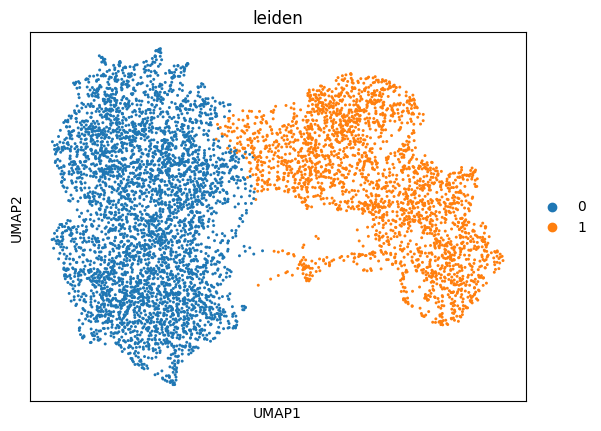

In [14]:
# Plot a UMAP embedding.
sc.pl.umap(adata, color= 'leiden', color_map= cmp_pspace)

(-68.28090909090909, 2115.899090909091, -67.68806853582555, 2115.9914953271027)

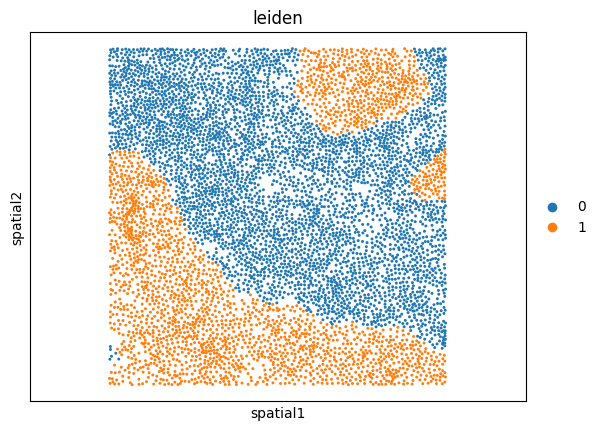

In [15]:
# Display a spatial embedding plot with clustering information.
ax = sc.pl.embedding(adata, basis= 'spatial', color='leiden', show= False, color_map=cmp_pspace)
ax.axis('equal')